# Task-1: 50% Biomass Case

In [190]:
# Import libaries
import pandas as pd
from oemof import solph
from oemof.tools import economics

import matplotlib.pyplot as plt
from collections import OrderedDict

In [191]:
#%% Read input data
# Input Data Reading
timeseries_50 = pd.read_excel('../data/input_data_assignment2.xls', 
                           sheet_name='timeseries', 
                           index_col=[0], 
                           parse_dates=True)

# Add timestep (oemof model needs time increment)
timeseries_50.index.freq = '1H'

capacities_50 = pd.read_excel('../data/input_data_assignment2.xls', 
                           sheet_name='capacity', 
                           index_col=[0], 
                           parse_dates=True)
tech_50 = pd.read_excel('../data/input_data_assignment2.xls', 
                           sheet_name='tech', 
                           index_col=[0], 
                           parse_dates=True)
costs_50 = pd.read_excel('../data/input_data_assignment2.xls', 
                           sheet_name='costs', 
                           index_col=[0], 
                           parse_dates=True)

In [192]:
#%% Initialize the energy system and read/calculate necessary parameters
energysystem_50 = solph.EnergySystem(timeindex=timeseries_50.index)

In [193]:
#%% Create oemof Buses

# create electricity bus
bus_electricity_50 = solph.Bus(label='bus_electricity_l')
# create heat bus
bus_heat_50 = solph.Bus(label='bus_heat_l')
# create biomass bus
bus_biomass_50 = solph.Bus(label='bus_biomass_l')

# add buses to energy model
energysystem_50.add(bus_electricity_50, bus_heat_50, bus_biomass_50)

In [194]:
#%% Create oemof Sinks

# create excess component for the electricity bus to allow overproduction
electricity_excess_50 = solph.Sink(label='electricty_excess_l', 
                                inputs={bus_electricity_50: solph.Flow()})

# create simple sink object representing the electrical demand
electricity_demand_50 = solph.Sink(label='electricity_demand_l',
                                inputs={bus_electricity_50: solph.Flow(
                                        fix=timeseries_50['electricity'], 
                                        nominal_value=capacities_50['electricity']['amount'])})

# create excess component for the heat bus to allow overproduction
heat_excess_50 = solph.Sink(label='heat_excess_l', 
                         inputs={bus_heat_50: solph.Flow()})

# create simple sink object representing the heat demand (space heat and hot water demand)
heat_space_demand_50 = solph.Sink(label='heat_space_demand_l',
                               inputs={bus_heat_50: solph.Flow(
                                       fix=timeseries_50['space_heat'], 
                                       nominal_value=capacities_50['space_heat']['amount'])})

heat_dhw_demand_50 = solph.Sink(label='heat_dhw_demand_l',
                             inputs={bus_heat_50: solph.Flow(
                                     fix=timeseries_50['dhw_heat'], 
                                     nominal_value=capacities_50['dhw_heat']['amount'])})

In [195]:
#%% Economic caluclation (for dispatch/sizing optimization) 

## Capital costs_50 [€/MW(h)]
# Annuities [€/MW(h)/a]
a_onshore_50 = economics.annuity(capex=costs_50['onshore']['capex'], 
                              n=costs_50['onshore']['lifetime'],
                              wacc=costs_50['onshore']['wacc'])
a_offshore_50 = economics.annuity(capex=costs_50['offshore']['capex'], 
                               n=costs_50['offshore']['lifetime'],
                               wacc=costs_50['offshore']['wacc'])
a_pv_50 = economics.annuity(capex=costs_50['pv']['capex'], 
                         n=costs_50['pv']['lifetime'],
                         wacc=costs_50['pv']['wacc'])
a_ror_50 = economics.annuity(capex=costs_50['ror']['capex'], 
                          n=costs_50['ror']['lifetime'],
                          wacc=costs_50['ror']['wacc'])

a_chp_50 = economics.annuity(capex=costs_50['chp']['capex'], 
                            n=costs_50['chp']['lifetime'],
                            wacc=costs_50['chp']['wacc'])
a_hp_50 = economics.annuity(capex=costs_50['hp']['capex'], 
                           n=costs_50['hp']['lifetime'],
                           wacc=costs_50['hp']['wacc'])

a_battery_energy_50 = economics.annuity(capex=costs_50['battery']['capex_energy'], 
                                     n=costs_50['battery']['lifetime'],
                                     wacc=costs_50['battery']['wacc'])
a_battery_50 = economics.annuity(capex=costs_50['battery']['capex'], 
                              n=costs_50['battery']['lifetime'],
                              wacc=costs_50['battery']['wacc'])
a_hydrogen_energy_50 = economics.annuity(capex=costs_50['hydrogen']['capex_energy'], 
                                      n=costs_50['hydrogen']['lifetime'],
                                      wacc=costs_50['hydrogen']['wacc'])
a_hydrogen_50 = economics.annuity(capex=costs_50['hydrogen']['capex'], 
                               n=costs_50['hydrogen']['lifetime'],
                               wacc=costs_50['hydrogen']['wacc'])
a_acaes_energy_50 = economics.annuity(capex=costs_50['acaes']['capex_energy'], 
                                     n=costs_50['acaes']['lifetime'],
                                     wacc=costs_50['acaes']['wacc'])
a_acaes_50 = economics.annuity(capex=costs_50['acaes']['capex'], 
                              n=costs_50['acaes']['lifetime'],
                              wacc=costs_50['acaes']['wacc'])
a_tes_energy_50 = economics.annuity(capex=costs_50['tes']['capex_energy'], 
                                   n=costs_50['tes']['lifetime'],
                                       wacc=costs_50['tes']['wacc'])


In [196]:
# Capital costs_50 sum of annuities and fixed opex [€/MW(h)/a]
cc_onshore_50 = (a_onshore_50 + costs_50['onshore']['fom'])
cc_offshore_50 = (a_offshore_50 + costs_50['offshore']['fom'])
cc_pv_50 = (a_pv_50 + costs_50['pv']['fom'])
cc_ror_50 = (a_ror_50 + costs_50['ror']['fom'])

cc_chp_50 = (a_chp_50 + costs_50['chp']['fom'])
cc_hp_50 = (a_hp_50 + costs_50['hp']['fom'])

cc_battery_energy_50 = (a_battery_energy_50 + costs_50['battery']['fom'])
cc_battery_50 = (a_battery_50)
cc_hydrogen_energy_50 = (a_hydrogen_energy_50 + costs_50['hydrogen']['fom'])
cc_hydrogen_50 = (a_hydrogen_50)
cc_acaes_energy_50 = (a_acaes_energy_50 + costs_50['acaes']['fom'])
cc_acaes_50 = (a_acaes_50)
cc_tes_energy_50 = (a_tes_energy_50 + costs_50['tes']['fom'])

In [197]:
## Marginal costs_50 [€/MWh/a]
mc_onshore_50 = costs_50['onshore']['vom']
mc_offshore_50 = costs_50['offshore']['vom']
mc_pv_50 = costs_50['pv']['vom']
mc_ror_50 = costs_50['ror']['vom']

mc_chp_50 = (costs_50['chp']['vom'])
mc_hp_50 = costs_50['hp']['vom']

mc_battery_50 = costs_50['battery']['vom']
mc_hydrogen_50 = costs_50['hydrogen']['vom']
mc_acaes_50 = costs_50['acaes']['vom']
mc_tes_50 = costs_50['tes']['vom']

In [198]:
#%%Create oemof Sources

# create fixed source object representing wind power plants offshore
wind_offshore_50 = solph.Source(label='wind_offshore_l',
                             outputs={bus_electricity_50: solph.Flow(   
                                     fix=timeseries_50['offshore'], 
                                     variable_costs=mc_offshore_50,
                                     investment=solph.Investment(
                                                ep_costs=cc_offshore_50,
                                                maximum=capacities_50['offshore']['capacity_potential'],
                                                existing=capacities_50['offshore']['capacity_existing']))
                                    },)

# create fixed source object representing wind power plants onshore
wind_onshore_50 = solph.Source(label='wind_onshore_l',
                            outputs={bus_electricity_50: solph.Flow(
                                    fix=timeseries_50['onshore'], 
                                    variable_costs=mc_onshore_50,
                                    investment=solph.Investment(
                                               ep_costs=cc_onshore_50,
                                               maximum=capacities_50['onshore']['capacity_potential'],
                                               existing=capacities_50['onshore']['capacity_existing']))
                                    },)

# create fixed source object representing pv power plants
pv_50 = solph.Source(label='pv_l',
                  outputs={bus_electricity_50: solph.Flow(
                           fix=timeseries_50['pv'], 
                           variable_costs=mc_pv_50,
                           investment=solph.Investment(
                                      ep_costs=cc_pv_50,
                                      maximum=capacities_50['pv']['capacity_potential'],
                                      existing=capacities_50['pv']['capacity_existing']))
                           },)

# create fixed source object representing hydro run of river plant
ror_50 = solph.Source(label='ror_l',
                   outputs={bus_electricity_50: solph.Flow(
                            fix=timeseries_50['ror'], 
                            variable_costs=mc_ror_50,
                            investment=solph.Investment(
                                       ep_costs=cc_ror_50,
                                       maximum=capacities_50['ror']['capacity_potential'],
                                       existing=capacities_50['ror']['capacity_existing']))
                            },)

# create fixed source object representing biomass ressource
biomass_50_50 = solph.Source(label='biomass_l',
                       outputs={bus_biomass_50: solph.Flow(
                               nominal_value=capacities_50['biomass']['capacity_potential'],
                               summed_max=1)
                               },)
                                   	

In [199]:
#%% Create oemof Storages

# create storage object representing a battery
battery_50 = solph.components.GenericStorage(label='battery_l',
                                          inputs={bus_electricity_50: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_battery_50,
                                                             maximum=capacities_50['battery']['storage_power_potential']),
                                                  variable_costs=mc_battery_50)},
                                          outputs={bus_electricity_50: solph.Flow()},
                                          loss_rate=tech_50['battery']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_50['battery']['max_hours'],
                                          invest_relation_output_capacity=1/tech_50['battery']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_50['battery']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_battery_energy_50,
                                                     maximum=capacities_50['battery']['capacity_potential']),)

# create storage object representing a hydrogen
hydrogen_50 = solph.components.GenericStorage(label='hydrogen_l',
                                          inputs={bus_electricity_50: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_hydrogen_50,
                                                             maximum=capacities_50['hydrogen']['storage_power_potential']),
                                                  variable_costs=mc_hydrogen_50)},
                                          outputs={bus_electricity_50: solph.Flow()},
                                          loss_rate=tech_50['hydrogen']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_50['hydrogen']['max_hours'],
                                          invest_relation_output_capacity=1/tech_50['hydrogen']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_50['hydrogen']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_hydrogen_energy_50,
                                                     maximum=capacities_50['hydrogen']['capacity_potential']),)

# create storage object representing a adiabatic compressed air energy storage (ACAES)
acaes_50 = solph.components.GenericStorage(label='acaes_l',
                                          inputs={bus_electricity_50: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_acaes_50,
                                                             maximum=capacities_50['acaes']['storage_power_potential']),
                                                  variable_costs=mc_acaes_50)},
                                          outputs={bus_electricity_50: solph.Flow()},
                                          loss_rate=tech_50['acaes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_50['acaes']['max_hours'],
                                          invest_relation_output_capacity=1/tech_50['acaes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_50['acaes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_acaes_energy_50,
                                                     maximum=capacities_50['acaes']['capacity_potential']),)

# create storage object representing a battery
tes_50 = solph.components.GenericStorage(label='tes_l',
                                          inputs={bus_heat_50: solph.Flow(
                                                  investment=solph.Investment(
                                                             maximum=capacities_50['tes']['storage_power_potential']),
                                                  variable_costs=mc_tes_50)},
                                          outputs={bus_heat_50: solph.Flow()},
                                          loss_rate=tech_50['tes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_50['tes']['max_hours'],
                                          invest_relation_output_capacity=1/tech_50['tes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_50['tes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_tes_energy_50,
                                                     maximum=capacities_50['tes']['capacity_potential']),)

In [200]:
#%% Create oemof Transormers

# create transformer object representing CHP plants
chp_50 = solph.Transformer(label='chp_l',
                        inputs={bus_biomass_50: solph.Flow(
                                    variable_costs=mc_chp_50)},
                        outputs={bus_electricity_50: solph.Flow(
                                    investment=solph.Investment(
                                               ep_costs=cc_chp_50,
                                               existing=capacities_50['chp']['capacity_existing'])),
                                 bus_heat_50: solph.Flow()},
                        conversion_factors={bus_electricity_50: tech_50['chp']['electric_efficiency'],
                                            bus_heat_50: tech_50['chp']['thermal_efficiency']},
                        )

# create transformer object representing heat pumps
hp_50 = solph.Transformer(label='hp_l',
                       inputs={bus_electricity_50: solph.Flow()},
                       outputs={bus_heat_50: solph.Flow(
                                investment=solph.Investment(
                                           ep_costs=cc_hp_50),
                                variable_costs=mc_hp_50)},
                       conversion_factors={bus_electricity_50: 1/tech_50['hp']['efficiency']},
                       )

In [201]:
#%% Add all components to the energysystem
energysystem_50.add(electricity_excess_50, electricity_demand_50,
                 heat_excess_50, heat_space_demand_50, heat_dhw_demand_50,
                 wind_offshore_50, wind_onshore_50, pv_50, ror_50, biomass_50_50,
                 battery_50, hydrogen_50, acaes_50, tes_50, 
                 hp_50, chp_50)

In [202]:
#%% Optimise the energy system

# initialise the operational model
om = solph.Model(energysystem_50)

# if tee_switch is true solver messages will be displayed
om.solve(solver='cbc')


{'Problem': [{'Name': 'unknown', 'Lower bound': 3411556517.0, 'Upper bound': 3411556517.0, 'Number of objectives': 1, 'Number of constraints': 245298, 'Number of variables': 210263, 'Number of nonzeros': 35047, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 368.79, 'Wallclock time': 369.96, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 95700}}, 'Error rc': 0, 'Time': 370.06837248802185}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [203]:
#Extract main results save results to dump (optional)
energysystem_50.results['main'] = solph.processing.results(om)
energysystem_50.dump('../results/dumps',
                  filename='model_50.oemof')

'Attributes dumped to: ../results/dumps/model_50.oemof'

In [204]:
#%% Extract results_50 

# Extract results_50 dict
results_50 = solph.processing.results(om)

# Extract component results_50
results_wind_offshore_50 = solph.views.node(results_50, 'wind_offshore_l')
results_wind_onshore_50 = solph.views.node(results_50, 'wind_onshore_l')
results_pv_50 = solph.views.node(results_50, 'pv_l')
results_ror_50 = solph.views.node(results_50, 'ror_l')

results_biomass_50 = solph.views.node(results_50, 'bus_biomass_l')
results_chp_50 = solph.views.node(results_50, 'chp_l')
results_hp_50 = solph.views.node(results_50, 'hp_l')

results_battery_50 = solph.views.node(results_50, 'battery_l')
results_hydrogen_50 = solph.views.node(results_50, 'hydrogen_l')
results_acaes_50 = solph.views.node(results_50, 'acaes_l')
results_tes_50 = solph.views.node(results_50, 'tes_l')

# Extract bus results_50
results_electricity_bus_50 = solph.views.node(results_50, 'bus_electricity_l')
results_heat_bus_50 = solph.views.node(results_50, 'bus_heat_l')
results_biomass_bus_50 = solph.views.node(results_50, 'bus_biomass_l')

In [205]:
#%% results_50: Installed capacities
# Define capacity_50 results_50 dict
results_capacity_50 = OrderedDict()

# installed capacity_50 of wind power plant in MW
results_capacity_50['wind_onshore_invest_MW'] = results_50[(wind_onshore_50, bus_electricity_50)]['scalars']['invest']
# installed capacity_50 of wind power plant in MW
results_capacity_50['wind_offshore_invest_MW'] = results_50[(wind_offshore_50, bus_electricity_50)]['scalars']['invest']
# installed capacity_50 of pv power plant in MW
results_capacity_50['pv_invest_MW'] = results_50[(pv_50, bus_electricity_50)]['scalars']['invest']
# installed capacity_50 of pv power plant in MW
results_capacity_50['ror_invest_MW'] = results_50[(ror_50, bus_electricity_50)]['scalars']['invest']

# installed capacity_50 of chp plant in MW
results_capacity_50['chp_invest_MW_el'] = results_50[(chp_50, bus_electricity_50)]['scalars']['invest']
# installed capacity_50 of heat pump in MW
results_capacity_50['hp_invest_MW_th'] = results_50[(hp_50, bus_heat_50)]['scalars']['invest']

# installed capacity_50 of battery storage in MWh
results_capacity_50['battery_invest_MWh'] = results_50[(battery_50, None)]['scalars']['invest']
# installed power capacity_50 of battery storage in MW
results_capacity_50['battery_invest_MW_ch'] = results_50[(bus_electricity_50, battery_50)]['scalars']['invest']
results_capacity_50['battery_invest_MW_dch'] = results_50[(battery_50, bus_electricity_50)]['scalars']['invest']

# installed capacity_50 of hydrogen storage in MWh
results_capacity_50['hydrogen_invest_MWh'] = results_50[(hydrogen_50, None)]['scalars']['invest']
# installed power capacity_50 of hydrogen storage in MW
results_capacity_50['hydrogen_invest_MW_ch'] = results_50[(bus_electricity_50, hydrogen_50)]['scalars']['invest']
results_capacity_50['hydrogen_invest_MW_dch'] = results_50[(hydrogen_50, bus_electricity_50,)]['scalars']['invest']

# installed capacity_50 of acaes storage in MWh
results_capacity_50['acaes_invest_MWh'] = results_50[(acaes_50, None)]['scalars']['invest']
# installed power capacity_50 of acaes storage in MW
results_capacity_50['acaes_invest_MW_ch'] = results_50[(bus_electricity_50, acaes_50)]['scalars']['invest']
results_capacity_50['acaes_invest_MW_dch'] = results_50[(acaes_50, bus_electricity_50)]['scalars']['invest']

# installed capacity_50 of thermal storage in MWh
results_capacity_50['thermal_storage_invest_MWh'] = results_50[(tes_50, None)]['scalars']['invest']
# installed power capacity_50 of thermal storage in MW
results_capacity_50['thermal_storage_invest_MW_ch'] = results_50[(bus_heat_50, tes_50)]['scalars']['invest']
results_capacity_50['thermal_storage_invest_MW_dch'] = results_50[(tes_50, bus_heat_50)]['scalars']['invest']

# Transfer dict to DataFRame and transpose for better readybility
results_capacity_50_df = pd.DataFrame(results_capacity_50, index=[0]).T
results_capacity_50_df.columns = ["capacity_50"]
results_capacity_50_df.round(3)

,capacity_50
wind_onshore_invest_MW,1936.000
wind_offshore_invest_MW,1211.376
pv_invest_MW,6771.000
ror_invest_MW,4.000
chp_invest_MW_el,994.437
hp_invest_MW_th,6794.658
battery_invest_MWh,5388.500
battery_invest_MW_ch,829.000
battery_invest_MW_dch,829.000
hydrogen_invest_MWh,42081.467


# Task-1-2: Calculate Capacity Costs (capex and fom)

In [206]:
#%% Results: Installed capacities
# Define capacity results dict
results_fom_50 = OrderedDict()

# installed capacity of wind power plant in MW
results_fom_50['wind_onshore_fom'] = (results_50[(wind_onshore_50, bus_electricity_50)]['scalars']['invest']*costs['onshore']['fom'])/1e6
# installed capacity of wind power plant in MW
results_fom_50['wind_offshore_fom'] = (results_50[(wind_offshore_50, bus_electricity_50)]['scalars']['invest']*costs['offshore']['fom'])/1e6
# installed capacity of pv power plant in MW
results_fom_50['pv_fom'] = (results_50[(pv_50, bus_electricity_50)]['scalars']['invest']*costs['pv']['fom'])/1e6
# installed capacity of pv power plant in MW
results_fom_50['ror_fom'] = (results_50[(ror_50, bus_electricity_50)]['scalars']['invest']*costs['ror']['fom'])/1e6

# installed capacity of chp plant in MW
results_fom_50['chp_fom_el'] = (results_50[(chp_50, bus_electricity_50)]['scalars']['invest']*costs['chp']['fom'])/1e6
# installed capacity of heat pump in MW
results_fom_50['hp_fom_th'] = (results_50[(hp_50, bus_heat_50)]['scalars']['invest']*costs['hp']['fom'])/1e6

# installed power capacity of battery storage in MW
results_fom_50['battery_fom_ch'] = (results_50[(bus_electricity_50, battery_50)]['scalars']['invest']*costs['battery']['fom'])/1e6
results_fom_50['battery_fom_dch'] = (results_50[(battery_50, bus_electricity_50)]['scalars']['invest']*costs['battery']['fom'])/1e6

# installed power capacity of hydrogen storage in MW
results_fom_50['hydrogen_fom_ch'] = (results_50[(bus_electricity_50, hydrogen_50)]['scalars']['invest']*costs['hydrogen']['fom'])/1e6
results_fom_50['hydrogen_fom_dch'] = (results_50[(hydrogen_50, bus_electricity_50,)]['scalars']['invest']*costs['hydrogen']['fom'])/1e6/1e6

# installed power capacity of acaes storage in MW
results_fom_50['acaes_fom_ch'] = (results_50[(bus_electricity_50, acaes_50)]['scalars']['invest']*costs['acaes']['fom'])/1e6
results_fom_50['acaes_fom_dch'] = (results_50[(acaes_50, bus_electricity_50)]['scalars']['invest']*costs['acaes']['fom'])/1e6

# installed power capacity of thermal storage in MW
results_fom_50['thermal_storage_fom_ch'] = (results_50[(bus_heat_50, tes_50)]['scalars']['invest']*costs['tes']['fom'])/1e6
results_fom_50['thermal_storage_fom_dch'] = (results_50[(tes_50, bus_heat_50)]['scalars']['invest']*costs['tes']['fom'])/1e6

# Transfer dict to DataFRame and transpose for better readybility
results_fom_50_df = pd.DataFrame(results_fom_50, index=[0]).T
results_fom_50_df.columns = ["fom (Mil$)"]
results_fom_50_df.round(3)

,fom (Mil$)
wind_onshore_fom,67.760
wind_offshore_fom,96.910
pv_fom,169.275
ror_fom,0.240
chp_fom_el,99.444
hp_fom_th,332.938
battery_fom_ch,8.290
battery_fom_dch,8.290
hydrogen_fom_ch,2.505
hydrogen_fom_dch,0.000


In [207]:
#%% Results: Installed capacities
# Define capacity results dict
results_capex_50 = OrderedDict()

# installed capacity of wind power plant in MW
results_capex_50['wind_onshore_capex'] = (results_50[(wind_onshore_50, bus_electricity_50)]['scalars']['invest']*costs_50['onshore']['capex'])/1e6
# installed capacity of wind power plant in MW
results_capex_50['wind_offshore_capex'] = (results_50[(wind_offshore_50, bus_electricity_50)]['scalars']['invest']*costs_50['offshore']['capex'])/1e6
# installed capacity of pv power plant in MW
results_capex_50['pv_capex'] = (results_50[(pv_50, bus_electricity_50)]['scalars']['invest']*costs_50['pv']['capex'])/1e6
# installed capacity of pv power plant in MW
results_capex_50['ror_capex'] = (results_50[(ror_50, bus_electricity_50)]['scalars']['invest']*costs_50['ror']['capex'])/1e6

# installed capacity of chp plant in MW
results_capex_50['chp_capex_el'] = (results_50[(chp_50, bus_electricity_50)]['scalars']['invest']*costs_50['chp']['capex'])/1e6
# installed capacity of heat pump in MW
results_capex_50['hp_capex_th'] = (results_50[(hp_50, bus_heat_50)]['scalars']['invest']*costs_50['hp']['capex'])/1e6

# installed capacity of battery storage in MWh
results_capex_50['battery_capex'] = (results_50[(battery_50, None)]['scalars']['invest']*costs_50['battery']['capex_energy'])/1e6
# installed power capacity of battery storage in MW
results_capex_50['battery_capex_ch'] = (results_50[(bus_electricity_50, battery_50)]['scalars']['invest']*costs_50['battery']['capex'])/1e6
results_capex_50['battery_capex_dch'] = (results_50[(battery_50, bus_electricity_50)]['scalars']['invest']*costs_50['battery']['capex'])/1e6

# installed capacity of hydrogen storage in MWh
results_capex_50['hydrogen_capex'] = (results_50[(hydrogen_50, None)]['scalars']['invest']*costs_50['hydrogen']['capex_energy'])/1e6
# installed power capacity of hydrogen storage in MW
results_capex_50['hydrogen_capex_ch'] = (results_50[(bus_electricity_50, hydrogen_50)]['scalars']['invest']*costs_50['hydrogen']['capex'])/1e6
results_capex_50['hydrogen_capex_dch'] = (results_50[(hydrogen_50, bus_electricity_50)]['scalars']['invest']*costs_50['hydrogen']['capex'])/1e6

# installed capacity of acaes storage in MWh
results_capex_50['acaes_capex'] = (results_50[(acaes_50, None)]['scalars']['invest']*costs_50['acaes']['capex_energy'])/1e6
# installed power capacity of acaes storage in MW
results_capex_50['acaes_capex_ch'] = (results_50[(bus_electricity_50, acaes_50)]['scalars']['invest']*costs_50['acaes']['capex'])/1e6
results_capex_50['acaes_capex_dch'] = (results_50[(acaes_50, bus_electricity_50)]['scalars']['invest']*costs_50['acaes']['capex'])/1e6

# installed capacity of thermal storage in MWh
results_capex_50['thermal_storage_capex'] = (results_50[(tes_50, None)]['scalars']['invest']*costs_50['tes']['capex_energy'])/1e6
# installed power capacity of thermal storage in MW
results_capex_50['thermal_storage_capex_ch'] = (results_50[(bus_heat_50, tes_50)]['scalars']['invest']*costs_50['tes']['capex_energy'])/1e6
results_capex_50['thermal_storage_capex_dch'] = (results_50[(tes_50, bus_heat_50)]['scalars']['invest']*costs_50['tes']['capex_energy'])/1e6

# Transfer dict to DataFRame and transpose for better readybility
results_capex_50_df = pd.DataFrame(results_capex_50, index=[0]).T
results_capex_50_df.columns = ["Capex (Mil$)"]
results_capex_50_df.round(3)

,Capex (Mil$)
wind_onshore_capex,2081.200
wind_offshore_capex,2535.411
pv_capex,2877.675
ror_capex,12.000
chp_capex_el,1940.146
hp_capex_th,9512.521
battery_capex,1007.650
battery_capex_ch,29.015
battery_capex_dch,29.015
hydrogen_capex,8.416


In [208]:
#%% Collection of all results and exporting to ecxel file

# Create a Pandas Excel writer using XlsxWriter as the engine.
with pd.ExcelWriter('../results/results_overview_50.xlsx', engine='xlsxwriter') as writer:  
    
    # Write each dataframe to a different worksheet.
    results_capacity_50_df.to_excel(writer, sheet_name='capacities')
    results_fom_50_df.to_excel(writer, sheet_name='fom')
    results_capex_50_df.to_excel(writer, sheet_name='capex')

# Task-1-4: Calculate State of Charge

In [210]:
results_soc_elec = OrderedDict()
# Extract results to plot
results_soc_elec['battery'] = results_50[(bus_electricity_50, battery_50)]['sequences']['flow']
results_soc_elec['battery'] = results_50[(battery_50, bus_electricity_50)]['sequences']['flow']

results_soc_elec['hydrogen'] = results_50[(bus_electricity_50, hydrogen_50)]['sequences']['flow']
results_soc_elec['hydrogen'] = results_50[(hydrogen_50, bus_electricity_50)]['sequences']['flow']

results_soc_elec['acaes'] = results_50[(bus_electricity_50, acaes_50)]['sequences']['flow']
results_soc_elec['acaes'] = results_50[(acaes_50, bus_electricity_50)]['sequences']['flow']

results_soc_elec['tes'] = results_50[(bus_heat_50, tes_50)]['sequences']['flow']
results_soc_elec['tes'] = results_50[(tes_50, bus_heat_50)]['sequences']['flow']

results_soc_elec['elec_demand'] = results_50[(bus_electricity_50, electricity_demand_50)]['sequences']['flow']
results_soc_elec['elec_excess'] = results_50[(bus_electricity_50, electricity_excess_50)]['sequences']['flow']

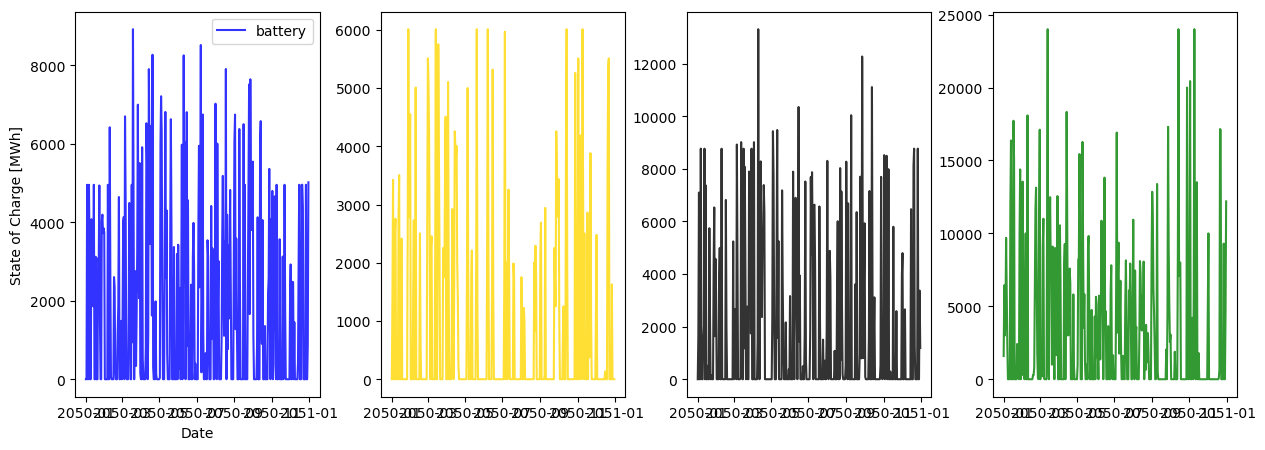

In [211]:
#%% Overview plot

#Resample timestep to 1 day               
freq_sample='D'
set_alpha=0.8

# Inilialize figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5) , sharey=False,sharex=False)
plt.subplots_adjust(wspace=0.25, hspace=0.05)

axes[0].plot(results_soc_elec['battery'].resample(freq_sample).sum(), alpha=set_alpha, color='blue', label='battery')
axes[1].plot(results_soc_elec['hydrogen'].resample(freq_sample).sum(), alpha=set_alpha, color='gold', label='hydrogen')
axes[2].plot(results_soc_elec['acaes'].resample(freq_sample).sum(), alpha=set_alpha, color='black', label='acaes')
axes[3].plot(results_soc_elec['tes'].resample(freq_sample).sum(), alpha=set_alpha, color='green', label='tes')

#axes[0].plot(results_soc_elec['elec_demand'].resample(freq_sample).sum(), alpha=set_alpha, color='magenta', label='Electricty demand')
#axes[0].plot(results_elec_ts['elec_excess'].resample(freq_sample).sum(), alpha=set_alpha, color='cyan', label='Electricty excess')

#axes[0].set_ylim(0, 10000)
axes[0].legend()
axes[0].set_ylabel('State of Charge [MWh]')
axes[0].set_xlabel('Date')

plt.show()
fig.savefig('../results/analysis_ts_overview.png', dpi=300)

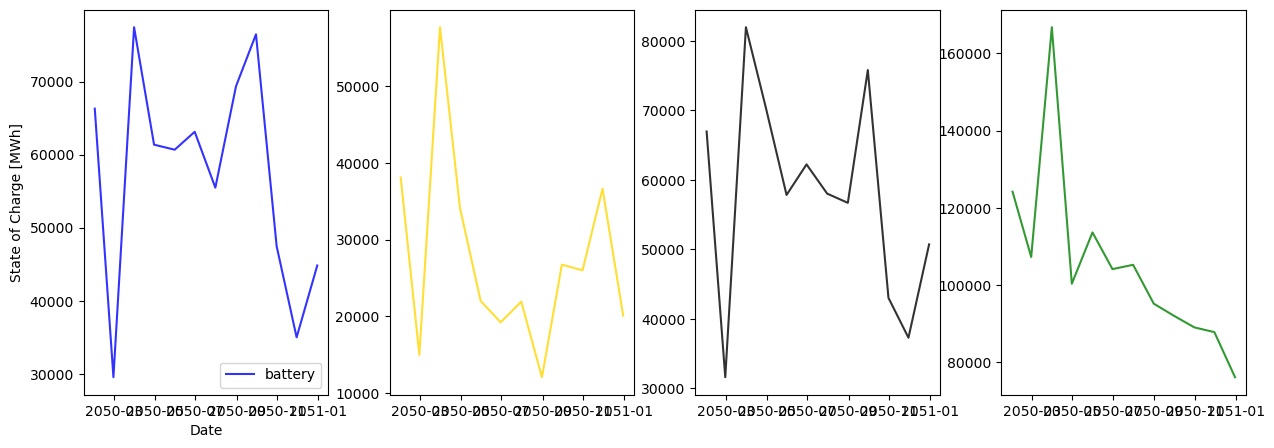

In [212]:
#%% Overview plot

#Resample timestep to 1 day               
freq_sample='M'
set_alpha=0.8

# Inilialize figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5) , sharey=False,sharex=False)
plt.subplots_adjust(wspace=0.25, hspace=0.05)

axes[0].plot(results_soc_elec['battery'].resample(freq_sample).sum(), alpha=set_alpha, color='blue', label='battery')
axes[1].plot(results_soc_elec['hydrogen'].resample(freq_sample).sum(), alpha=set_alpha, color='gold', label='hydrogen')
axes[2].plot(results_soc_elec['acaes'].resample(freq_sample).sum(), alpha=set_alpha, color='black', label='acaes')
axes[3].plot(results_soc_elec['tes'].resample(freq_sample).sum(), alpha=set_alpha, color='green', label='tes')

#axes[0].plot(results_soc_elec['elec_demand'].resample(freq_sample).sum(), alpha=set_alpha, color='magenta', label='Electricty demand')
#axes[0].plot(results_elec_ts['elec_excess'].resample(freq_sample).sum(), alpha=set_alpha, color='cyan', label='Electricty excess')

#axes[0].set_ylim(0, 10000)
axes[0].legend()
axes[0].set_ylabel('State of Charge [MWh]')
axes[0].set_xlabel('Date')

plt.show()
fig.savefig('../results/analysis_ts_overview.png', dpi=300)

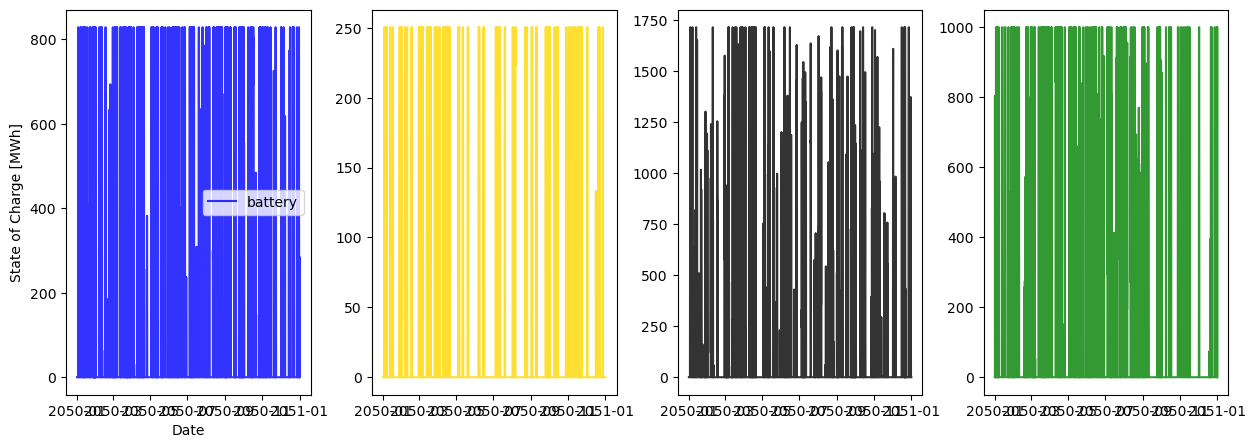

In [213]:
#%% Overview plot

#Resample timestep to 1 day               
freq_sample='H'
set_alpha=0.8

# Inilialize figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5) , sharey=False,sharex=False)
plt.subplots_adjust(wspace=0.25, hspace=0.05)

axes[0].plot(results_soc_elec['battery'].resample(freq_sample).mean(), alpha=set_alpha, color='blue', label='battery')
axes[1].plot(results_soc_elec['hydrogen'].resample(freq_sample).mean(), alpha=set_alpha, color='gold', label='hydrogen')
axes[2].plot(results_soc_elec['acaes'].resample(freq_sample).mean(), alpha=set_alpha, color='black', label='acaes')
axes[3].plot(results_soc_elec['tes'].resample(freq_sample).mean(), alpha=set_alpha, color='green', label='tes')

#axes[0].plot(results_soc_elec['elec_demand'].resample(freq_sample).sum(), alpha=set_alpha, color='magenta', label='Electricty demand')
#axes[0].plot(results_elec_ts['elec_excess'].resample(freq_sample).sum(), alpha=set_alpha, color='cyan', label='Electricty excess')

#axes[0].set_ylim(0, 10000)
axes[0].legend()
axes[0].set_ylabel('State of Charge [MWh]')
axes[0].set_xlabel('Date')


print = ('The mean annual State of Charge of battery is', results_soc_elec['battery'].mean())
print = ('The mean annual State of Charge of acaes is', results_soc_elec['acaes'].mean())
print = ('The mean annual State of Charge of hydrogen is', results_soc_elec['hydrogen'].mean())
print = ('The mean annual State of Charge of tes is', results_soc_elec['tes'].mean())


plt.show()
fig.savefig('../results/analysis_ts_overview.png', dpi=300)

# Task-1-1 (Effect of Parameter Change)

In [214]:
#%% Read input data
# Input Data Reading
timeseries = pd.read_excel('../data/input_data_assignment2_1-1.xls', 
                           sheet_name='timeseries', 
                           index_col=[0], 
                           parse_dates=True)

# Add timestep (oemof model needs time increment)
timeseries.index.freq = '1H'

capacities = pd.read_excel('../data/input_data_assignment2_1-1.xls', 
                           sheet_name='capacity', 
                           index_col=[0], 
                           parse_dates=True)
tech = pd.read_excel('../data/input_data_assignment2_1-1.xls', 
                           sheet_name='tech', 
                           index_col=[0], 
                           parse_dates=True)
costs = pd.read_excel('../data/input_data_assignment2_1-1.xls', 
                           sheet_name='costs', 
                           index_col=[0], 
                           parse_dates=True)



/home/shahzaibkhn7/micromamba/envs/sustainable_energy/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/shahzaibkhn7/micromamba/envs/sustainable_energy/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [215]:
#%% Initialize the energy system and read/calculate necessary parameters
energysystem_param = solph.EnergySystem(timeindex=timeseries.index)

In [216]:
#%% Create oemof Buses

# create electricity bus
bus_electricity = solph.Bus(label='bus_electricity_l')
# create heat bus
bus_heat = solph.Bus(label='bus_heat_l')
# create biomass bus
bus_biomass = solph.Bus(label='bus_biomass_l')

# add buses to energy model
energysystem_param.add(bus_electricity, bus_heat, bus_biomass)

In [217]:
#%% Create oemof Sinks

# create excess component for the electricity bus to allow overproduction
electricity_excess = solph.Sink(label='electricty_excess_l', 
                                inputs={bus_electricity: solph.Flow()})

# create simple sink object representing the electrical demand
electricity_demand = solph.Sink(label='electricity_demand_l',
                                inputs={bus_electricity: solph.Flow(
                                        fix=timeseries['electricity'], 
                                        nominal_value=capacities['electricity']['amount'])})

# create excess component for the heat bus to allow overproduction
heat_excess = solph.Sink(label='heat_excess_l', 
                         inputs={bus_heat: solph.Flow()})

# create simple sink object representing the heat demand (space heat and hot water demand)
heat_space_demand = solph.Sink(label='heat_space_demand_l',
                               inputs={bus_heat: solph.Flow(
                                       fix=timeseries['space_heat'], 
                                       nominal_value=capacities['space_heat']['amount'])})

heat_dhw_demand = solph.Sink(label='heat_dhw_demand_l',
                             inputs={bus_heat: solph.Flow(
                                     fix=timeseries['dhw_heat'], 
                                     nominal_value=capacities['dhw_heat']['amount'])})

In [218]:
#%% Economic caluclation (for dispatch/sizing optimization) 

## Capital costs [€/MW(h)]
# Annuities [€/MW(h)/a]
a_onshore = economics.annuity(capex=costs['onshore']['capex'], 
                              n=costs['onshore']['lifetime'],
                              wacc=costs['onshore']['wacc'])
a_offshore = economics.annuity(capex=costs['offshore']['capex'], 
                               n=costs['offshore']['lifetime'],
                               wacc=costs['offshore']['wacc'])
a_pv = economics.annuity(capex=costs['pv']['capex'], 
                         n=costs['pv']['lifetime'],
                         wacc=costs['pv']['wacc'])
a_ror = economics.annuity(capex=costs['ror']['capex'], 
                          n=costs['ror']['lifetime'],
                          wacc=costs['ror']['wacc'])

a_chp = economics.annuity(capex=costs['chp']['capex'], 
                            n=costs['chp']['lifetime'],
                            wacc=costs['chp']['wacc'])
a_hp = economics.annuity(capex=costs['hp']['capex'], 
                           n=costs['hp']['lifetime'],
                           wacc=costs['hp']['wacc'])

a_battery_energy = economics.annuity(capex=costs['battery']['capex_energy'], 
                                     n=costs['battery']['lifetime'],
                                     wacc=costs['battery']['wacc'])
a_battery = economics.annuity(capex=costs['battery']['capex'], 
                              n=costs['battery']['lifetime'],
                              wacc=costs['battery']['wacc'])
a_hydrogen_energy = economics.annuity(capex=costs['hydrogen']['capex_energy'], 
                                      n=costs['hydrogen']['lifetime'],
                                      wacc=costs['hydrogen']['wacc'])
a_hydrogen = economics.annuity(capex=costs['hydrogen']['capex'], 
                               n=costs['hydrogen']['lifetime'],
                               wacc=costs['hydrogen']['wacc'])
a_acaes_energy = economics.annuity(capex=costs['acaes']['capex_energy'], 
                                     n=costs['acaes']['lifetime'],
                                     wacc=costs['acaes']['wacc'])
a_acaes = economics.annuity(capex=costs['acaes']['capex'], 
                              n=costs['acaes']['lifetime'],
                              wacc=costs['acaes']['wacc'])
a_tes_energy = economics.annuity(capex=costs['tes']['capex_energy'], 
                                   n=costs['tes']['lifetime'],
                                       wacc=costs['tes']['wacc'])


In [219]:
# Capital costs sum of annuities and fixed opex [€/MW(h)/a]
cc_onshore = (a_onshore + costs['onshore']['fom'])
cc_offshore = (a_offshore + costs['offshore']['fom'])
cc_pv = (a_pv + costs['pv']['fom'])
cc_ror = (a_ror + costs['ror']['fom'])

cc_chp = (a_chp + costs['chp']['fom'])
cc_hp = (a_hp + costs['hp']['fom'])

cc_battery_energy = (a_battery_energy + costs['battery']['fom'])
cc_battery = (a_battery)
cc_hydrogen_energy = (a_hydrogen_energy + costs['hydrogen']['fom'])
cc_hydrogen = (a_hydrogen)
cc_acaes_energy = (a_acaes_energy + costs['acaes']['fom'])
cc_acaes = (a_acaes)
cc_tes_energy = (a_tes_energy + costs['tes']['fom'])

In [220]:
## Marginal costs [€/MWh/a]
mc_onshore = costs['onshore']['vom']
mc_offshore = costs['offshore']['vom']
mc_pv = costs['pv']['vom']
mc_ror = costs['ror']['vom']

mc_chp = (costs['chp']['vom'])
mc_hp = costs['hp']['vom']

mc_battery = costs['battery']['vom']
mc_hydrogen = costs['hydrogen']['vom']
mc_acaes = costs['acaes']['vom']
mc_tes = costs['tes']['vom']

In [221]:
#%%Create oemof Sources

# create fixed source object representing wind power plants offshore
wind_offshore = solph.Source(label='wind_offshore_l',
                             outputs={bus_electricity: solph.Flow(   
                                     fix=timeseries['offshore'], 
                                     variable_costs=mc_offshore,
                                     investment=solph.Investment(
                                                ep_costs=cc_offshore,
                                                maximum=capacities['offshore']['capacity_potential'],
                                                existing=capacities['offshore']['capacity_existing']))
                                    },)

# create fixed source object representing wind power plants onshore
wind_onshore = solph.Source(label='wind_onshore_l',
                            outputs={bus_electricity: solph.Flow(
                                    fix=timeseries['onshore'], 
                                    variable_costs=mc_onshore,
                                    investment=solph.Investment(
                                               ep_costs=cc_onshore,
                                               maximum=capacities['onshore']['capacity_potential'],
                                               existing=capacities['onshore']['capacity_existing']))
                                    },)

# create fixed source object representing pv power plants
pv = solph.Source(label='pv_l',
                  outputs={bus_electricity: solph.Flow(
                           fix=timeseries['pv'], 
                           variable_costs=mc_pv,
                           investment=solph.Investment(
                                      ep_costs=cc_pv,
                                      maximum=capacities['pv']['capacity_potential'],
                                      existing=capacities['pv']['capacity_existing']))
                           },)

# create fixed source object representing hydro run of river plant
ror = solph.Source(label='ror_l',
                   outputs={bus_electricity: solph.Flow(
                            fix=timeseries['ror'], 
                            variable_costs=mc_ror,
                            investment=solph.Investment(
                                       ep_costs=cc_ror,
                                       maximum=capacities['ror']['capacity_potential'],
                                       existing=capacities['ror']['capacity_existing']))
                            },)

# create fixed source object representing biomass ressource
biomass = solph.Source(label='biomass_l',
                       outputs={bus_biomass: solph.Flow(
                               nominal_value=capacities['biomass']['capacity_potential'],
                               summed_max=1)
                               },)
                                   	

In [222]:
#%% Create oemof Storages

# create storage object representing a battery
battery = solph.components.GenericStorage(label='battery_l',
                                          inputs={bus_electricity: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_battery,
                                                             maximum=capacities['battery']['storage_power_potential']),
                                                  variable_costs=mc_battery)},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['battery']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['battery']['max_hours'],
                                          invest_relation_output_capacity=1/tech['battery']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['battery']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_battery_energy,
                                                     maximum=capacities['battery']['capacity_potential']),)

# create storage object representing a hydrogen
hydrogen = solph.components.GenericStorage(label='hydrogen_l',
                                          inputs={bus_electricity: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_hydrogen,
                                                             maximum=capacities['hydrogen']['storage_power_potential']),
                                                  variable_costs=mc_hydrogen)},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['hydrogen']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['hydrogen']['max_hours'],
                                          invest_relation_output_capacity=1/tech['hydrogen']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['hydrogen']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_hydrogen_energy,
                                                     maximum=capacities['hydrogen']['capacity_potential']),)

# create storage object representing a adiabatic compressed air energy storage (ACAES)
acaes = solph.components.GenericStorage(label='acaes_l',
                                          inputs={bus_electricity: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_acaes,
                                                             maximum=capacities['acaes']['storage_power_potential']),
                                                  variable_costs=mc_acaes)},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['acaes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['acaes']['max_hours'],
                                          invest_relation_output_capacity=1/tech['acaes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['acaes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_acaes_energy,
                                                     maximum=capacities['acaes']['capacity_potential']),)

# create storage object representing a battery
tes = solph.components.GenericStorage(label='tes_l',
                                          inputs={bus_heat: solph.Flow(
                                                  investment=solph.Investment(
                                                             maximum=capacities['tes']['storage_power_potential']),
                                                  variable_costs=mc_tes)},
                                          outputs={bus_heat: solph.Flow()},
                                          loss_rate=tech['tes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['tes']['max_hours'],
                                          invest_relation_output_capacity=1/tech['tes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['tes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_tes_energy,
                                                     maximum=capacities['tes']['capacity_potential']),)

In [223]:
#%% Create oemof Transormers

# create transformer object representing CHP plants
chp = solph.Transformer(label='chp_l',
                        inputs={bus_biomass: solph.Flow(
                                    variable_costs=mc_chp)},
                        outputs={bus_electricity: solph.Flow(
                                    investment=solph.Investment(
                                               ep_costs=cc_chp,
                                               existing=capacities['chp']['capacity_existing'])),
                                 bus_heat: solph.Flow()},
                        conversion_factors={bus_electricity: tech['chp']['electric_efficiency'],
                                            bus_heat: tech['chp']['thermal_efficiency']},
                        )

# create transformer object representing heat pumps
hp = solph.Transformer(label='hp_l',
                       inputs={bus_electricity: solph.Flow()},
                       outputs={bus_heat: solph.Flow(
                                investment=solph.Investment(
                                           ep_costs=cc_hp),
                                variable_costs=mc_hp)},
                       conversion_factors={bus_electricity: 1/tech['hp']['efficiency']},
                       )

In [224]:
#%% Add all components to the energysystem
energysystem_param.add(electricity_excess, electricity_demand,
                 heat_excess, heat_space_demand, heat_dhw_demand,
                 wind_offshore, wind_onshore, pv, ror, biomass,
                 battery, hydrogen, acaes, tes, 
                 hp, chp)

In [225]:
#%% Optimise the energy system

# initialise the operational model
om = solph.Model(energysystem_param)

# if tee_switch is true solver messages will be displayed
om.solve(solver='cbc')


{'Problem': [{'Name': 'unknown', 'Lower bound': 2410204951.0, 'Upper bound': 2410204951.0, 'Number of objectives': 1, 'Number of constraints': 245298, 'Number of variables': 210263, 'Number of nonzeros': 35047, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 379.04, 'Wallclock time': 380.15, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 84237}}, 'Error rc': 0, 'Time': 380.24621415138245}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [226]:
#Extract main results save results to dump (optional)
energysystem_param.results['main'] = solph.processing.results(om)
energysystem_param.dump('../results/dumps',
                  filename='model_param.oemof')

'Attributes dumped to: ../results/dumps/model_param.oemof'

In [227]:
#%% Extract results 

# Extract results dict
results = solph.processing.results(om)

# Extract component results
results_wind_offshore = solph.views.node(results, 'wind_offshore_l')
results_wind_onshore = solph.views.node(results, 'wind_onshore_l')
results_pv = solph.views.node(results, 'pv_l')
results_ror = solph.views.node(results, 'ror_l')

results_biomass = solph.views.node(results, 'bus_biomass_l')
results_chp = solph.views.node(results, 'chp_l')
results_hp = solph.views.node(results, 'hp_l')

results_battery = solph.views.node(results, 'battery_l')
results_hydrogen = solph.views.node(results, 'hydrogen_l')
results_acaes = solph.views.node(results, 'acaes_l')
results_tes = solph.views.node(results, 'tes_l')

# Extract bus results
results_electricity_bus = solph.views.node(results, 'bus_electricity_l')
results_heat_bus = solph.views.node(results, 'bus_heat_l')
results_biomass_bus = solph.views.node(results, 'bus_biomass_l')

In [228]:
#%% Results: Installed capacities
# Define capacity results dict
results_capacity = OrderedDict()

# installed capacity of wind power plant in MW
results_capacity['wind_onshore_invest_MW'] = results[(wind_onshore, bus_electricity)]['scalars']['invest']
# installed capacity of wind power plant in MW
results_capacity['wind_offshore_invest_MW'] = results[(wind_offshore, bus_electricity)]['scalars']['invest']
# installed capacity of pv power plant in MW
results_capacity['pv_invest_MW'] = results[(pv, bus_electricity)]['scalars']['invest']
# installed capacity of pv power plant in MW
results_capacity['ror_invest_MW'] = results[(ror, bus_electricity)]['scalars']['invest']

# installed capacity of chp plant in MW
results_capacity['chp_invest_MW_el'] = results[(chp, bus_electricity)]['scalars']['invest']
# installed capacity of heat pump in MW
results_capacity['hp_invest_MW_th'] = results[(hp, bus_heat)]['scalars']['invest']

# installed capacity of battery storage in MWh
results_capacity['battery_invest_MWh'] = results[(battery, None)]['scalars']['invest']
# installed power capacity of battery storage in MW
results_capacity['battery_invest_MW_ch'] = results[(bus_electricity, battery)]['scalars']['invest']
results_capacity['battery_invest_MW_dch'] = results[(battery, bus_electricity)]['scalars']['invest']

# installed capacity of hydrogen storage in MWh
results_capacity['hydrogen_invest_MWh'] = results[(hydrogen, None)]['scalars']['invest']
# installed power capacity of hydrogen storage in MW
results_capacity['hydrogen_invest_MW_ch'] = results[(bus_electricity, hydrogen)]['scalars']['invest']
results_capacity['hydrogen_invest_MW_dch'] = results[(hydrogen, bus_electricity,)]['scalars']['invest']

# installed capacity of acaes storage in MWh
results_capacity['acaes_invest_MWh'] = results[(acaes, None)]['scalars']['invest']
# installed power capacity of acaes storage in MW
results_capacity['acaes_invest_MW_ch'] = results[(bus_electricity, acaes)]['scalars']['invest']
results_capacity['acaes_invest_MW_dch'] = results[(acaes, bus_electricity)]['scalars']['invest']

# installed capacity of thermal storage in MWh
results_capacity['thermal_storage_invest_MWh'] = results[(tes, None)]['scalars']['invest']
# installed power capacity of thermal storage in MW
results_capacity['thermal_storage_invest_MW_ch'] = results[(bus_heat, tes)]['scalars']['invest']
results_capacity['thermal_storage_invest_MW_dch'] = results[(tes, bus_heat)]['scalars']['invest']

# Transfer dict to DataFRame and transpose for better readybility
results_capacity_df = pd.DataFrame(results_capacity, index=[0]).T
results_capacity_df

,0
wind_onshore_invest_MW,620.05622
wind_offshore_invest_MW,0.00000
pv_invest_MW,6771.00000
ror_invest_MW,4.00000
chp_invest_MW_el,1333.00540
hp_invest_MW_th,6588.95240
battery_invest_MWh,5388.50000
battery_invest_MW_ch,829.00000
battery_invest_MW_dch,829.00000
hydrogen_invest_MWh,0.00000


In [229]:
#%% Collection of all results and exporting to ecxel file

# Create a Pandas Excel writer using XlsxWriter as the engine.
with pd.ExcelWriter('../results/results_overview_param.xlsx', engine='xlsxwriter') as writer:  
    
    # Write each dataframe to a different worksheet.
    results_capacity_df.to_excel(writer, sheet_name='capacities')


# Task-2: 25% Biomass Case

In [230]:
#%% Read input data
# Input Data Reading
timeseries_25 = pd.read_excel('../data/input_data_assignment2_1.xls', 
                           sheet_name='timeseries', 
                           index_col=[0], 
                           parse_dates=True)

# Add timestep (oemof model needs time increment)
timeseries_25.index.freq = '1H'

capacities_25 = pd.read_excel('../data/input_data_assignment2_1.xls', 
                           sheet_name='capacity', 
                           index_col=[0], 
                           parse_dates=True)
tech_25 = pd.read_excel('../data/input_data_assignment2_1.xls', 
                           sheet_name='tech', 
                           index_col=[0], 
                           parse_dates=True)
costs_25 = pd.read_excel('../data/input_data_assignment2_1.xls', 
                           sheet_name='costs', 
                           index_col=[0], 
                           parse_dates=True)

/home/shahzaibkhn7/micromamba/envs/sustainable_energy/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/shahzaibkhn7/micromamba/envs/sustainable_energy/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [231]:
#%% Initialize the energy system and read/calculate necessary parameters
energysystem_25 = solph.EnergySystem(timeindex=timeseries_25.index)

In [232]:
#%% Create oemof Buses

# create electricity bus
bus_electricity_25 = solph.Bus(label='bus_electricity_l')
# create heat bus
bus_heat_25 = solph.Bus(label='bus_heat_l')
# create biomass bus
bus_biomass_25 = solph.Bus(label='bus_biomass_l')

# add buses to energy model
energysystem_25.add(bus_electricity_25, bus_heat_25, bus_biomass_25)

In [233]:
#%% Create oemof Sinks

# create excess component for the electricity bus to allow overproduction
electricity_excess_25 = solph.Sink(label='electricty_excess_l', 
                                inputs={bus_electricity_25: solph.Flow()})

# create simple sink object representing the electrical demand
electricity_demand_25= solph.Sink(label='electricity_demand_l',
                                inputs={bus_electricity_25: solph.Flow(
                                        fix=timeseries_25['electricity'], 
                                        nominal_value=capacities_25['electricity']['amount'])})

# create excess component for the heat bus to allow overproduction
heat_excess_25 = solph.Sink(label='heat_excess_l', 
                         inputs={bus_heat_25: solph.Flow()})

# create simple sink object representing the heat demand (space heat and hot water demand)
heat_space_demand_25 = solph.Sink(label='heat_space_demand_l',
                               inputs={bus_heat_25: solph.Flow(
                                       fix=timeseries_25['space_heat'], 
                                       nominal_value=capacities_25['space_heat']['amount'])})

heat_dhw_demand_25 = solph.Sink(label='heat_dhw_demand_l',
                             inputs={bus_heat_25: solph.Flow(
                                     fix=timeseries_25['dhw_heat'], 
                                     nominal_value=capacities_25['dhw_heat']['amount'])})

In [234]:
#%% Economic caluclation (for dispatch/sizing optimization) 

## Capital costs_25 [€/MW(h)]
# Annuities [€/MW(h)/a]
a_onshore_25 = economics.annuity(capex=costs_25['onshore']['capex'], 
                              n=costs_25['onshore']['lifetime'],
                              wacc=costs_25['onshore']['wacc'])
a_offshore_25 = economics.annuity(capex=costs_25['offshore']['capex'], 
                               n=costs_25['offshore']['lifetime'],
                               wacc=costs_25['offshore']['wacc'])
a_pv_25 = economics.annuity(capex=costs_25['pv']['capex'], 
                         n=costs_25['pv']['lifetime'],
                         wacc=costs_25['pv']['wacc'])
a_ror_25 = economics.annuity(capex=costs_25['ror']['capex'], 
                          n=costs_25['ror']['lifetime'],
                          wacc=costs_25['ror']['wacc'])

a_chp_25 = economics.annuity(capex=costs_25['chp']['capex'], 
                            n=costs_25['chp']['lifetime'],
                            wacc=costs_25['chp']['wacc'])
a_hp_25 = economics.annuity(capex=costs_25['hp']['capex'], 
                           n=costs_25['hp']['lifetime'],
                           wacc=costs_25['hp']['wacc'])

a_battery_energy_25 = economics.annuity(capex=costs_25['battery']['capex_energy'], 
                                     n=costs_25['battery']['lifetime'],
                                     wacc=costs_25['battery']['wacc'])
a_battery_25 = economics.annuity(capex=costs_25['battery']['capex'], 
                              n=costs_25['battery']['lifetime'],
                              wacc=costs_25['battery']['wacc'])
a_hydrogen_energy_25 = economics.annuity(capex=costs_25['hydrogen']['capex_energy'], 
                                      n=costs_25['hydrogen']['lifetime'],
                                      wacc=costs_25['hydrogen']['wacc'])
a_hydrogen_25 = economics.annuity(capex=costs_25['hydrogen']['capex'], 
                               n=costs_25['hydrogen']['lifetime'],
                               wacc=costs_25['hydrogen']['wacc'])
a_acaes_energy_25 = economics.annuity(capex=costs_25['acaes']['capex_energy'], 
                                     n=costs_25['acaes']['lifetime'],
                                     wacc=costs_25['acaes']['wacc'])
a_acaes_25 = economics.annuity(capex=costs_25['acaes']['capex'], 
                              n=costs_25['acaes']['lifetime'],
                              wacc=costs_25['acaes']['wacc'])
a_tes_energy_25 = economics.annuity(capex=costs_25['tes']['capex_energy'], 
                                   n=costs_25['tes']['lifetime'],
                                       wacc=costs_25['tes']['wacc'])


In [235]:
# Capital costs_25 sum of annuities and fixed opex [€/MW(h)/a]
cc_onshore_25 = (a_onshore_25 + costs_25['onshore']['fom'])
cc_offshore_25 = (a_offshore_25 + costs_25['offshore']['fom'])
cc_pv_25 = (a_pv_25 + costs_25['pv']['fom'])
cc_ror_25 = (a_ror_25 + costs_25['ror']['fom'])

cc_chp_25 = (a_chp_25 + costs_25['chp']['fom'])
cc_hp_25 = (a_hp_25 + costs_25['hp']['fom'])

cc_battery_energy_25 = (a_battery_energy_25 + costs_25['battery']['fom'])
cc_battery_25 = (a_battery_25)
cc_hydrogen_energy_25 = (a_hydrogen_energy_25 + costs_25['hydrogen']['fom'])
cc_hydrogen_25 = (a_hydrogen_25)
cc_acaes_energy_25 = (a_acaes_energy_25 + costs_25['acaes']['fom'])
cc_acaes_25 = (a_acaes_25)
cc_tes_energy_25 = (a_tes_energy_25 + costs_25['tes']['fom'])

In [236]:
## Marginal costs_25 [€/MWh/a]
mc_onshore_25 = costs_25['onshore']['vom']
mc_offshore_25 = costs_25['offshore']['vom']
mc_pv_25 = costs_25['pv']['vom']
mc_ror_25 = costs_25['ror']['vom']

mc_chp_25 = (costs_25['chp']['vom'])
mc_hp_25 = costs_25['hp']['vom']

mc_battery_25 = costs_25['battery']['vom']
mc_hydrogen_25 = costs_25['hydrogen']['vom']
mc_acaes_25 = costs_25['acaes']['vom']
mc_tes_25 = costs_25['tes']['vom']

In [237]:
#%%Create oemof Sources

# create fixed source object representing wind power plants offshore
wind_offshore_25 = solph.Source(label='wind_offshore_l',
                             outputs={bus_electricity_25: solph.Flow(   
                                     fix=timeseries_25['offshore'], 
                                     variable_costs=mc_offshore_25,
                                     investment=solph.Investment(
                                                ep_costs=cc_offshore_25,
                                                maximum=capacities_25['offshore']['capacity_potential'],
                                                existing=capacities_25['offshore']['capacity_existing']))
                                    },)

# create fixed source object representing wind power plants onshore
wind_onshore_25 = solph.Source(label='wind_onshore_l',
                            outputs={bus_electricity_25: solph.Flow(
                                    fix=timeseries_25['onshore'], 
                                    variable_costs=mc_onshore_25,
                                    investment=solph.Investment(
                                               ep_costs=cc_onshore_25,
                                               maximum=capacities_25['onshore']['capacity_potential'],
                                               existing=capacities_25['onshore']['capacity_existing']))
                                    },)

# create fixed source object representing pv power plants
pv_25 = solph.Source(label='pv_l',
                  outputs={bus_electricity_25: solph.Flow(
                           fix=timeseries_25['pv'], 
                           variable_costs=mc_pv_25,
                           investment=solph.Investment(
                                      ep_costs=cc_pv_25,
                                      maximum=capacities_25['pv']['capacity_potential'],
                                      existing=capacities_25['pv']['capacity_existing']))
                           },)

# create fixed source object representing hydro run of river plant
ror_25 = solph.Source(label='ror_l',
                   outputs={bus_electricity_25: solph.Flow(
                            fix=timeseries_25['ror'], 
                            variable_costs=mc_ror_25,
                            investment=solph.Investment(
                                       ep_costs=cc_ror_25,
                                       maximum=capacities_25['ror']['capacity_potential'],
                                       existing=capacities_25['ror']['capacity_existing']))
                            },)

# create fixed source object representing biomass ressource
biomass_25 = solph.Source(label='biomass_l',
                       outputs={bus_biomass_25: solph.Flow(
                               nominal_value=capacities_25['biomass']['capacity_potential'],
                               summed_max=1)
                               },)
                                   	

In [238]:
#%% Create oemof Storages

# create storage object representing a battery
battery_25 = solph.components.GenericStorage(label='battery_l',
                                          inputs={bus_electricity_25: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_battery_25,
                                                             maximum=capacities_25['battery']['storage_power_potential']),
                                                  variable_costs=mc_battery_25)},
                                          outputs={bus_electricity_25: solph.Flow()},
                                          loss_rate=tech_25['battery']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_25['battery']['max_hours'],
                                          invest_relation_output_capacity=1/tech_25['battery']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_25['battery']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_battery_energy_25,
                                                     maximum=capacities_25['battery']['capacity_potential']),)

# create storage object representing a hydrogen
hydrogen_25 = solph.components.GenericStorage(label='hydrogen_l',
                                          inputs={bus_electricity_25: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_hydrogen_25,
                                                             maximum=capacities_25['hydrogen']['storage_power_potential']),
                                                  variable_costs=mc_hydrogen_25)},
                                          outputs={bus_electricity_25: solph.Flow()},
                                          loss_rate=tech_25['hydrogen']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_25['hydrogen']['max_hours'],
                                          invest_relation_output_capacity=1/tech_25['hydrogen']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_25['hydrogen']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_hydrogen_energy_25,
                                                     maximum=capacities_25['hydrogen']['capacity_potential']),)

# create storage object representing a adiabatic compressed air energy storage (ACAES)
acaes_25 = solph.components.GenericStorage(label='acaes_l',
                                          inputs={bus_electricity_25: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_acaes_25,
                                                             maximum=capacities_25['acaes']['storage_power_potential']),
                                                  variable_costs=mc_acaes_25)},
                                          outputs={bus_electricity_25: solph.Flow()},
                                          loss_rate=tech_25['acaes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_25['acaes']['max_hours'],
                                          invest_relation_output_capacity=1/tech_25['acaes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_25['acaes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_acaes_energy_25,
                                                     maximum=capacities_25['acaes']['capacity_potential']),)

# create storage object representing a battery
tes_25 = solph.components.GenericStorage(label='tes_l',
                                          inputs={bus_heat_25: solph.Flow(
                                                  investment=solph.Investment(
                                                             maximum=capacities_25['tes']['storage_power_potential']),
                                                  variable_costs=mc_tes_25)},
                                          outputs={bus_heat_25: solph.Flow()},
                                          loss_rate=tech_25['tes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_25['tes']['max_hours'],
                                          invest_relation_output_capacity=1/tech_25['tes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_25['tes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_tes_energy_25,
                                                     maximum=capacities_25['tes']['capacity_potential']),)

In [239]:
#%% Create oemof Transormers

# create transformer object representing CHP plants
chp_25 = solph.Transformer(label='chp_l',
                        inputs={bus_biomass_25: solph.Flow(
                                    variable_costs=mc_chp_25)},
                        outputs={bus_electricity_25: solph.Flow(
                                    investment=solph.Investment(
                                               ep_costs=cc_chp_25,
                                               existing=capacities_25['chp']['capacity_existing'])),
                                 bus_heat: solph.Flow()},
                        conversion_factors={bus_electricity_25: tech_25['chp']['electric_efficiency'],
                                            bus_heat_25: tech_25['chp']['thermal_efficiency']},
                        )

# create transformer object representing heat pumps
hp_25 = solph.Transformer(label='hp_l',
                       inputs={bus_electricity_25: solph.Flow()},
                       outputs={bus_heat_25: solph.Flow(
                                investment=solph.Investment(
                                           ep_costs=cc_hp_25),
                                variable_costs=mc_hp_25)},
                       conversion_factors={bus_electricity_25: 1/tech_25['hp']['efficiency']},
                       )

In [240]:
#%% Add all components to the energysystem
energysystem_25.add(electricity_excess_25, electricity_demand_25,
                 heat_excess_25, heat_space_demand_25, heat_dhw_demand_25,
                 wind_offshore_25, wind_onshore_25, pv_25, ror_25, biomass_25,
                 battery_25, hydrogen_25, acaes_25, tes_25, 
                 hp_25, chp_25)

In [241]:
#%% Optimise the energy system

# initialise the operational model
om_25 = solph.Model(energysystem_25)

# if tee_switch is true solver messages will be displayed
om_25.solve(solver='cbc')


{'Problem': [{'Name': 'unknown', 'Lower bound': 5847410915.0, 'Upper bound': 5847410915.0, 'Number of objectives': 1, 'Number of constraints': 245298, 'Number of variables': 210263, 'Number of nonzeros': 35047, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 138.73, 'Wallclock time': 139.55, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 73146}}, 'Error rc': 0, 'Time': 139.6428418159485}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [242]:
#Extract main results save results to dump (optional)
energysystem_25.results['main'] = solph.processing.results(om_25)
energysystem_25.dump('../results/dumps',
                  filename='model_25.oemof')

'Attributes dumped to: ../results/dumps/model_25.oemof'

In [243]:
#%% Extract results 

# Extract results dict
results_25 = solph.processing.results(om_25)

# Extract component results
results_wind_offshore_25 = solph.views.node(results_25, 'wind_offshore_l')
results_wind_onshore_25 = solph.views.node(results_25, 'wind_onshore_l')
results_pv_25 = solph.views.node(results_25, 'pv_l')
results_ror_25 = solph.views.node(results_25, 'ror_l')

results_biomass_25 = solph.views.node(results_25, 'bus_biomass_l')
results_chp_25 = solph.views.node(results_25, 'chp_l')
results_hp_25 = solph.views.node(results_25, 'hp_l')

results_battery_25 = solph.views.node(results_25, 'battery_l')
results_hydrogen_25 = solph.views.node(results_25, 'hydrogen_l')
results_acaes_25 = solph.views.node(results_25, 'acaes_l')
results_tes_25 = solph.views.node(results_25, 'tes_l')

# Extract bus results
results_electricity_bus_25 = solph.views.node(results_25, 'bus_electricity_l')
results_heat_bus_25 = solph.views.node(results_25, 'bus_heat_l')
results_biomass_bus_25 = solph.views.node(results_25, 'bus_biomass_l')

In [244]:
#%% Results: Installed capacities
# Define capacity results dict
results_capacity_25 = OrderedDict()

# installed capacity of wind power plant in MW
results_capacity_25['wind_onshore_invest_MW'] = results_25[(wind_onshore_25, bus_electricity_25)]['scalars']['invest']
# installed capacity of wind power plant in MW
results_capacity_25['wind_offshore_invest_MW'] = results_25[(wind_offshore_25, bus_electricity_25)]['scalars']['invest']
# installed capacity of pv power plant in MW
results_capacity_25['pv_invest_MW'] = results_25[(pv_25, bus_electricity_25)]['scalars']['invest']
# installed capacity of pv power plant in MW
results_capacity_25['ror_invest_MW'] = results_25[(ror_25, bus_electricity_25)]['scalars']['invest']

# installed capacity of chp plant in MW
results_capacity_25['chp_invest_MW_el'] = results_25[(chp_25, bus_electricity_25)]['scalars']['invest']
# installed capacity of heat pump in MW
results_capacity_25['hp_invest_MW_th'] = results_25[(hp_25, bus_heat_25)]['scalars']['invest']

# installed capacity of battery storage in MWh
results_capacity_25['battery_invest_MWh'] = results_25[(battery_25, None)]['scalars']['invest']
# installed power capacity of battery storage in MW
results_capacity_25['battery_invest_MW_ch'] = results_25[(bus_electricity_25, battery_25)]['scalars']['invest']
results_capacity_25['battery_invest_MW_dch'] = results_25[(battery_25, bus_electricity_25)]['scalars']['invest']

# installed capacity of hydrogen storage in MWh
results_capacity_25['hydrogen_invest_MWh'] = results_25[(hydrogen_25, None)]['scalars']['invest']
# installed power capacity of hydrogen storage in MW
results_capacity_25['hydrogen_invest_MW_ch'] = results_25[(bus_electricity_25, hydrogen_25)]['scalars']['invest']
results_capacity_25['hydrogen_invest_MW_dch'] = results_25[(hydrogen_25, bus_electricity_25)]['scalars']['invest']

# installed capacity of acaes storage in MWh
results_capacity_25['acaes_invest_MWh'] = results_25[(acaes_25, None)]['scalars']['invest']
# installed power capacity of acaes storage in MW
results_capacity_25['acaes_invest_MW_ch'] = results_25[(bus_electricity_25, acaes_25)]['scalars']['invest']
results_capacity_25['acaes_invest_MW_dch'] = results_25[(acaes_25, bus_electricity_25)]['scalars']['invest']

# installed capacity of thermal storage in MWh
results_capacity_25['thermal_storage_invest_MWh'] = results_25[(tes_25, None)]['scalars']['invest']
# installed power capacity of thermal storage in MW
results_capacity_25['thermal_storage_invest_MW_ch'] = results_25[(bus_heat_25, tes_25)]['scalars']['invest']
results_capacity_25['thermal_storage_invest_MW_dch'] = results_25[(tes_25, bus_heat_25)]['scalars']['invest']

# Transfer dict to DataFRame and transpose for better readybility
results_capacity_25_df = pd.DataFrame(results_capacity_25, index=[0]).T
results_capacity_25_df

,0
wind_onshore_invest_MW,1936.0000
wind_offshore_invest_MW,9529.7033
pv_invest_MW,6771.0000
ror_invest_MW,4.0000
chp_invest_MW_el,1057.4860
hp_invest_MW_th,8184.0901
battery_invest_MWh,5388.5000
battery_invest_MW_ch,829.0000
battery_invest_MW_dch,829.0000
hydrogen_invest_MWh,84840.0840


In [245]:
#%% Collection of all results and exporting to ecxel file

# Create a Pandas Excel writer using XlsxWriter as the engine.
with pd.ExcelWriter('../results/results_overview_25.xlsx', engine='xlsxwriter') as writer:  
    
    # Write each dataframe to a different worksheet.
    results_capacity_25_df.to_excel(writer, sheet_name='capacities')


# Task-2: 100% Biomass Case

In [246]:
#%% Read input data
# Input Data Reading
timeseries_100 = pd.read_excel('../data/input_data_assignment2_2.xls', 
                           sheet_name='timeseries', 
                           index_col=[0], 
                           parse_dates=True)

# Add timestep (oemof model needs time increment)
timeseries_100.index.freq = '1H'

capacities_100 = pd.read_excel('../data/input_data_assignment2_2.xls', 
                           sheet_name='capacity', 
                           index_col=[0], 
                           parse_dates=True)
tech_100 = pd.read_excel('../data/input_data_assignment2_2.xls', 
                           sheet_name='tech', 
                           index_col=[0], 
                           parse_dates=True)
costs_100 = pd.read_excel('../data/input_data_assignment2_2.xls', 
                           sheet_name='costs', 
                           index_col=[0], 
                           parse_dates=True)



/home/shahzaibkhn7/micromamba/envs/sustainable_energy/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/shahzaibkhn7/micromamba/envs/sustainable_energy/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [247]:
#%% Initialize the energy system and read/calculate necessary parameters
energysystem_100 = solph.EnergySystem(timeindex=timeseries_100.index)

In [248]:
#%% Create oemof Buses

# create electricity bus
bus_electricity_100 = solph.Bus(label='bus_electricity_l')
# create heat bus
bus_heat_100 = solph.Bus(label='bus_heat_l')
# create biomass bus
bus_biomass_100 = solph.Bus(label='bus_biomass_l')

# add buses to energy model
energysystem_100.add(bus_electricity_100, bus_heat_100, bus_biomass_100)

In [249]:
#%% Create oemof Sinks

# create excess component for the electricity bus to allow overproduction
electricity_excess_100 = solph.Sink(label='electricty_excess_l', 
                                inputs={bus_electricity_100: solph.Flow()})

# create simple sink object representing the electrical demand
electricity_demand_100= solph.Sink(label='electricity_demand_l',
                                inputs={bus_electricity_100: solph.Flow(
                                        fix=timeseries_100['electricity'], 
                                        nominal_value=capacities_100['electricity']['amount'])})

# create excess component for the heat bus to allow overproduction
heat_excess_100 = solph.Sink(label='heat_excess_l', 
                         inputs={bus_heat_100: solph.Flow()})

# create simple sink object representing the heat demand (space heat and hot water demand)
heat_space_demand_100 = solph.Sink(label='heat_space_demand_l',
                               inputs={bus_heat_100: solph.Flow(
                                       fix=timeseries_100['space_heat'], 
                                       nominal_value=capacities_100['space_heat']['amount'])})

heat_dhw_demand_100 = solph.Sink(label='heat_dhw_demand_l',
                             inputs={bus_heat_100: solph.Flow(
                                     fix=timeseries_100['dhw_heat'], 
                                     nominal_value=capacities_100['dhw_heat']['amount'])})

In [250]:
#%% Economic caluclation (for dispatch/sizing optimization) 

## Capital costs_100 [€/MW(h)]
# Annuities [€/MW(h)/a]
a_onshore_100 = economics.annuity(capex=costs_100['onshore']['capex'], 
                              n=costs_100['onshore']['lifetime'],
                              wacc=costs_100['onshore']['wacc'])
a_offshore_100 = economics.annuity(capex=costs_100['offshore']['capex'], 
                               n=costs_100['offshore']['lifetime'],
                               wacc=costs_100['offshore']['wacc'])
a_pv_100 = economics.annuity(capex=costs_100['pv']['capex'], 
                         n=costs_100['pv']['lifetime'],
                         wacc=costs_100['pv']['wacc'])
a_ror_100 = economics.annuity(capex=costs_100['ror']['capex'], 
                          n=costs_100['ror']['lifetime'],
                          wacc=costs_100['ror']['wacc'])

a_chp_100 = economics.annuity(capex=costs_100['chp']['capex'], 
                            n=costs_100['chp']['lifetime'],
                            wacc=costs_100['chp']['wacc'])
a_hp_100 = economics.annuity(capex=costs_100['hp']['capex'], 
                           n=costs_100['hp']['lifetime'],
                           wacc=costs_100['hp']['wacc'])

a_battery_energy_100 = economics.annuity(capex=costs_100['battery']['capex_energy'], 
                                     n=costs_100['battery']['lifetime'],
                                     wacc=costs_100['battery']['wacc'])
a_battery_100 = economics.annuity(capex=costs_100['battery']['capex'], 
                              n=costs_100['battery']['lifetime'],
                              wacc=costs_100['battery']['wacc'])
a_hydrogen_energy_100 = economics.annuity(capex=costs_100['hydrogen']['capex_energy'], 
                                      n=costs_100['hydrogen']['lifetime'],
                                      wacc=costs_100['hydrogen']['wacc'])
a_hydrogen_100 = economics.annuity(capex=costs_100['hydrogen']['capex'], 
                               n=costs_100['hydrogen']['lifetime'],
                               wacc=costs_100['hydrogen']['wacc'])
a_acaes_energy_100 = economics.annuity(capex=costs_100['acaes']['capex_energy'], 
                                     n=costs_100['acaes']['lifetime'],
                                     wacc=costs_100['acaes']['wacc'])
a_acaes_100 = economics.annuity(capex=costs_100['acaes']['capex'], 
                              n=costs_100['acaes']['lifetime'],
                              wacc=costs_100['acaes']['wacc'])
a_tes_energy_100 = economics.annuity(capex=costs_100['tes']['capex_energy'], 
                                   n=costs_100['tes']['lifetime'],
                                       wacc=costs_100['tes']['wacc'])


In [251]:
# Capital costs_100 sum of annuities and fixed opex [€/MW(h)/a]
cc_onshore_100 = (a_onshore_100 + costs_100['onshore']['fom'])
cc_offshore_100 = (a_offshore_100 + costs_100['offshore']['fom'])
cc_pv_100 = (a_pv_100 + costs_100['pv']['fom'])
cc_ror_100 = (a_ror_100 + costs_100['ror']['fom'])

cc_chp_100 = (a_chp_100 + costs_100['chp']['fom'])
cc_hp_100 = (a_hp_100 + costs_100['hp']['fom'])

cc_battery_energy_100 = (a_battery_energy_100 + costs_100['battery']['fom'])
cc_battery_100 = (a_battery_100)
cc_hydrogen_energy_100 = (a_hydrogen_energy_100 + costs_100['hydrogen']['fom'])
cc_hydrogen_100 = (a_hydrogen_100)
cc_acaes_energy_100 = (a_acaes_energy_100 + costs_100['acaes']['fom'])
cc_acaes_100 = (a_acaes_100)
cc_tes_energy_100 = (a_tes_energy_100 + costs_100['tes']['fom'])

In [252]:
## Marginal costs_100 [€/MWh/a]
mc_onshore_100 = costs_100['onshore']['vom']
mc_offshore_100 = costs_100['offshore']['vom']
mc_pv_100 = costs_100['pv']['vom']
mc_ror_100 = costs_100['ror']['vom']

mc_chp_100 = (costs_100['chp']['vom'])
mc_hp_100 = costs_100['hp']['vom']

mc_battery_100 = costs_100['battery']['vom']
mc_hydrogen_100 = costs_100['hydrogen']['vom']
mc_acaes_100 = costs_100['acaes']['vom']
mc_tes_100 = costs_100['tes']['vom']

In [253]:
#%%Create oemof Sources

# create fixed source object representing wind power plants offshore
wind_offshore_100 = solph.Source(label='wind_offshore_l',
                             outputs={bus_electricity_100: solph.Flow(   
                                     fix=timeseries_100['offshore'], 
                                     variable_costs=mc_offshore_100,
                                     investment=solph.Investment(
                                                ep_costs=cc_offshore_100,
                                                maximum=capacities_100['offshore']['capacity_potential'],
                                                existing=capacities_100['offshore']['capacity_existing']))
                                    },)

# create fixed source object representing wind power plants onshore
wind_onshore_100 = solph.Source(label='wind_onshore_l',
                            outputs={bus_electricity_100: solph.Flow(
                                    fix=timeseries_100['onshore'], 
                                    variable_costs=mc_onshore_100,
                                    investment=solph.Investment(
                                               ep_costs=cc_onshore_100,
                                               maximum=capacities_100['onshore']['capacity_potential'],
                                               existing=capacities_100['onshore']['capacity_existing']))
                                    },)

# create fixed source object representing pv power plants
pv_100 = solph.Source(label='pv_l',
                  outputs={bus_electricity_100: solph.Flow(
                           fix=timeseries_100['pv'], 
                           variable_costs=mc_pv_100,
                           investment=solph.Investment(
                                      ep_costs=cc_pv_100,
                                      maximum=capacities_100['pv']['capacity_potential'],
                                      existing=capacities_100['pv']['capacity_existing']))
                           },)

# create fixed source object representing hydro run of river plant
ror_100 = solph.Source(label='ror_l',
                   outputs={bus_electricity_100: solph.Flow(
                            fix=timeseries_100['ror'], 
                            variable_costs=mc_ror_100,
                            investment=solph.Investment(
                                       ep_costs=cc_ror_100,
                                       maximum=capacities_100['ror']['capacity_potential'],
                                       existing=capacities_100['ror']['capacity_existing']))
                            },)

# create fixed source object representing biomass ressource
biomass_100 = solph.Source(label='biomass_l',
                       outputs={bus_biomass_100: solph.Flow(
                               nominal_value=capacities_100['biomass']['capacity_potential'],
                               summed_max=1)
                               },)
                                   	

In [254]:
#%% Create oemof Storages

# create storage object representing a battery
battery_100 = solph.components.GenericStorage(label='battery_l',
                                          inputs={bus_electricity_100: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_battery_100,
                                                             maximum=capacities_100['battery']['storage_power_potential']),
                                                  variable_costs=mc_battery_100)},
                                          outputs={bus_electricity_100: solph.Flow()},
                                          loss_rate=tech_100['battery']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_100['battery']['max_hours'],
                                          invest_relation_output_capacity=1/tech_100['battery']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_100['battery']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_battery_energy_100,
                                                     maximum=capacities_100['battery']['capacity_potential']),)

# create storage object representing a hydrogen
hydrogen_100 = solph.components.GenericStorage(label='hydrogen_l',
                                          inputs={bus_electricity_100: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_hydrogen_100,
                                                             maximum=capacities_100['hydrogen']['storage_power_potential']),
                                                  variable_costs=mc_hydrogen_100)},
                                          outputs={bus_electricity_100: solph.Flow()},
                                          loss_rate=tech_100['hydrogen']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_100['hydrogen']['max_hours'],
                                          invest_relation_output_capacity=1/tech_100['hydrogen']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_100['hydrogen']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_hydrogen_energy_100,
                                                     maximum=capacities_100['hydrogen']['capacity_potential']),)

# create storage object representing a adiabatic compressed air energy storage (ACAES)
acaes_100 = solph.components.GenericStorage(label='acaes_l',
                                          inputs={bus_electricity_100: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_acaes_100,
                                                             maximum=capacities_100['acaes']['storage_power_potential']),
                                                  variable_costs=mc_acaes_100)},
                                          outputs={bus_electricity_100: solph.Flow()},
                                          loss_rate=tech_100['acaes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_100['acaes']['max_hours'],
                                          invest_relation_output_capacity=1/tech_100['acaes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_100['acaes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_acaes_energy_100,
                                                     maximum=capacities_100['acaes']['capacity_potential']),)

# create storage object representing a battery
tes_100 = solph.components.GenericStorage(label='tes_l',
                                          inputs={bus_heat_100: solph.Flow(
                                                  investment=solph.Investment(
                                                             maximum=capacities_100['tes']['storage_power_potential']),
                                                  variable_costs=mc_tes_100)},
                                          outputs={bus_heat_100: solph.Flow()},
                                          loss_rate=tech_100['tes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech_100['tes']['max_hours'],
                                          invest_relation_output_capacity=1/tech_100['tes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech_100['tes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_tes_energy_100,
                                                     maximum=capacities_100['tes']['capacity_potential']),)

In [255]:
#%% Create oemof Transormers

# create transformer object representing CHP plants
chp_100 = solph.Transformer(label='chp_l',
                        inputs={bus_biomass_100: solph.Flow(
                                    variable_costs=mc_chp_100)},
                        outputs={bus_electricity_100: solph.Flow(
                                    investment=solph.Investment(
                                               ep_costs=cc_chp_100,
                                               existing=capacities_100['chp']['capacity_existing'])),
                                 bus_heat: solph.Flow()},
                        conversion_factors={bus_electricity_100: tech_100['chp']['electric_efficiency'],
                                            bus_heat_100: tech_100['chp']['thermal_efficiency']},
                        )

# create transformer object representing heat pumps
hp_100 = solph.Transformer(label='hp_l',
                       inputs={bus_electricity_100: solph.Flow()},
                       outputs={bus_heat_100: solph.Flow(
                                investment=solph.Investment(
                                           ep_costs=cc_hp_100),
                                variable_costs=mc_hp_100)},
                       conversion_factors={bus_electricity_100: 1/tech_100['hp']['efficiency']},
                       )

In [256]:
#%% Add all components to the energysystem
energysystem_100.add(electricity_excess_100, electricity_demand_100,
                 heat_excess_100, heat_space_demand_100, heat_dhw_demand_100,
                 wind_offshore_100, wind_onshore_100, pv_100, ror_100, biomass_100,
                 battery_100, hydrogen_100, acaes_100, tes_100, 
                 hp_100, chp_100)

In [257]:
#%% Optimise the energy system

# initialise the operational model
om_100 = solph.Model(energysystem_100)

# if tee_switch is true solver messages will be displayed
om_100.solve(solver='cbc')


{'Problem': [{'Name': 'unknown', 'Lower bound': 3134372695.0, 'Upper bound': 3134372695.0, 'Number of objectives': 1, 'Number of constraints': 245298, 'Number of variables': 210263, 'Number of nonzeros': 35047, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 209.81, 'Wallclock time': 210.85, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 73642}}, 'Error rc': 0, 'Time': 210.9495565891266}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [258]:
#Extract main results save results to dump (optional)
energysystem_100.results['main'] = solph.processing.results(om_100)
energysystem_100.dump('../results/dumps',
                  filename='model_100.oemof')

'Attributes dumped to: ../results/dumps/model_100.oemof'

In [259]:
#%% Extract results 

# Extract results dict
results_100 = solph.processing.results(om_100)

# Extract component results
results_wind_offshore_100 = solph.views.node(results_100, 'wind_offshore_l')
results_wind_onshore_100 = solph.views.node(results_100, 'wind_onshore_l')
results_pv_100 = solph.views.node(results_100, 'pv_l')
results_ror_100 = solph.views.node(results_100, 'ror_l')

results_biomass_100 = solph.views.node(results_100, 'bus_biomass_l')
results_chp_100 = solph.views.node(results_100, 'chp_l')
results_hp_100 = solph.views.node(results_100, 'hp_l')

results_battery_100 = solph.views.node(results_100, 'battery_l')
results_hydrogen_100 = solph.views.node(results_100, 'hydrogen_l')
results_acaes_100 = solph.views.node(results_100, 'acaes_l')
results_tes_100 = solph.views.node(results_100, 'tes_l')

# Extract bus results
results_electricity_bus_100 = solph.views.node(results_100, 'bus_electricity_l')
results_heat_bus_100 = solph.views.node(results_100, 'bus_heat_l')
results_biomass_bus_100 = solph.views.node(results_100, 'bus_biomass_l')

In [260]:
#%% Results: Installed capacities
# Define capacity results dict
results_capacity_100 = OrderedDict()

# installed capacity of wind power plant in MW
results_capacity_100['wind_onshore_invest_MW'] = results_100[(wind_onshore_100, bus_electricity_100)]['scalars']['invest']
# installed capacity of wind power plant in MW
results_capacity_100['wind_offshore_invest_MW'] = results_100[(wind_offshore_100, bus_electricity_100)]['scalars']['invest']
# installed capacity of pv power plant in MW
results_capacity_100['pv_invest_MW'] = results_100[(pv_100, bus_electricity_100)]['scalars']['invest']
# installed capacity of pv power plant in MW
results_capacity_100['ror_invest_MW'] = results_100[(ror_100, bus_electricity_100)]['scalars']['invest']

# installed capacity of chp plant in MW
results_capacity_100['chp_invest_MW_el'] = results_100[(chp_100, bus_electricity_100)]['scalars']['invest']
# installed capacity of heat pump in MW
results_capacity_100['hp_invest_MW_th'] = results_100[(hp_100, bus_heat_100)]['scalars']['invest']

# installed capacity of battery storage in MWh
results_capacity_100['battery_invest_MWh'] = results_100[(battery_100, None)]['scalars']['invest']
# installed power capacity of battery storage in MW
results_capacity_100['battery_invest_MW_ch'] = results_100[(bus_electricity_100, battery_100)]['scalars']['invest']
results_capacity_100['battery_invest_MW_dch'] = results_100[(battery_100, bus_electricity_100)]['scalars']['invest']

# installed capacity of hydrogen storage in MWh
results_capacity_100['hydrogen_invest_MWh'] = results_100[(hydrogen_100, None)]['scalars']['invest']
# installed power capacity of hydrogen storage in MW
results_capacity_100['hydrogen_invest_MW_ch'] = results_100[(bus_electricity_100, hydrogen_100)]['scalars']['invest']
results_capacity_100['hydrogen_invest_MW_dch'] = results_100[(hydrogen_100, bus_electricity_100)]['scalars']['invest']

# installed capacity of acaes storage in MWh
results_capacity_100['acaes_invest_MWh'] = results_100[(acaes_100, None)]['scalars']['invest']
# installed power capacity of acaes storage in MW
results_capacity_100['acaes_invest_MW_ch'] = results_100[(bus_electricity_100, acaes_100)]['scalars']['invest']
results_capacity_100['acaes_invest_MW_dch'] = results_100[(acaes_100, bus_electricity_100)]['scalars']['invest']

# installed capacity of thermal storage in MWh
results_capacity_100['thermal_storage_invest_MWh'] = results_100[(tes_100, None)]['scalars']['invest']
# installed power capacity of thermal storage in MW
results_capacity_100['thermal_storage_invest_MW_ch'] = results_100[(bus_heat_100, tes_100)]['scalars']['invest']
results_capacity_100['thermal_storage_invest_MW_dch'] = results_100[(tes_100, bus_heat_100)]['scalars']['invest']

# Transfer dict to DataFRame and transpose for better readybility
results_capacity_100_df = pd.DataFrame(results_capacity_100, index=[0]).T
results_capacity_100_df

,0
wind_onshore_invest_MW,332.00053
wind_offshore_invest_MW,0.00000
pv_invest_MW,6771.00000
ror_invest_MW,4.00000
chp_invest_MW_el,1806.45730
hp_invest_MW_th,8184.09010
battery_invest_MWh,5388.50000
battery_invest_MW_ch,829.00000
battery_invest_MW_dch,829.00000
hydrogen_invest_MWh,0.00000


In [261]:
#%% Collection of all results and exporting to ecxel file

# Create a Pandas Excel writer using XlsxWriter as the engine.
with pd.ExcelWriter('../results/results_overview_100.xlsx', engine='xlsxwriter') as writer:  
    
    # Write each dataframe to a different worksheet.
    results_capacity_100_df.to_excel(writer, sheet_name='capacities')
